## Stark Broadening Asymmetries From SPY

[The SPY survey](https://ui.adsabs.harvard.edu/abs/2020A%26A...638A.131N/abstract) has a ton of high-res WD spectra. I'm gonna see how much Stark broadening affects their absorption lines.

In [1]:
import glob
import os
import numpy as np

from astropy.io import ascii
from astropy.table import Table, join
import matplotlib.pyplot as plt
plt.style.use('../../proj/core-composition/notebooks/stefan.mplstyle')

In [2]:
from stark import catalog as ct
from stark import measure as meas

obj = ct.fetch_objfile()
sdss_wds = Table.read('./data/raw/25SDSS_inSPY.csv')
sdss_wds.remove_columns(['ra', 'dec'])
cat = join(obj, sdss_wds, keys_left='Name', keys_right='Name_2', join_type='inner')

Could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [3]:
spec, obj = ct.read_spectrum(cat, './data/raw/sp', download_files=True)

  0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


In [9]:
import json
#measured = meas.analyze_spectra(spec, './data/processed/25SDSS_inSPY_Habgd.json', from_cache=True)
# WD1736p052_b_2000_06_01T07_01_24_all.dat.gz
with open('./data/processed/25SDSS_inSPY_Habgd.json') as json_file:
    measured = json.load(json_file)

In [10]:
df = ct.tabularize(measured)
df_with_mask = ct.apply_rules(df, sigma = 3 , rv_over_err = 3, chisqr = 10)
df_masked = ct.apply_mask(df_with_mask, rows = ['rvs', 'e_rvs', 'differentials', 'significance', 
                                             'redchisqr', 'teff', 'e_teff', 'logg', 'e_logg'])

In [11]:
temp_bin_edges = [0, 12000, 16000]
df_binned, range_func, center_func = ct.bin_temperatures(df_masked, temp_bin_edges)

In [12]:
for edge in np.unique(df.teff_bin):
    print(f"{edge} | {range_func(edge)} : {(df['teff_bin'] == edge).sum()}")

1 | (0, 12000) : 19
2 | (12000, 16000) : 13
3 | (16000, inf) : 10


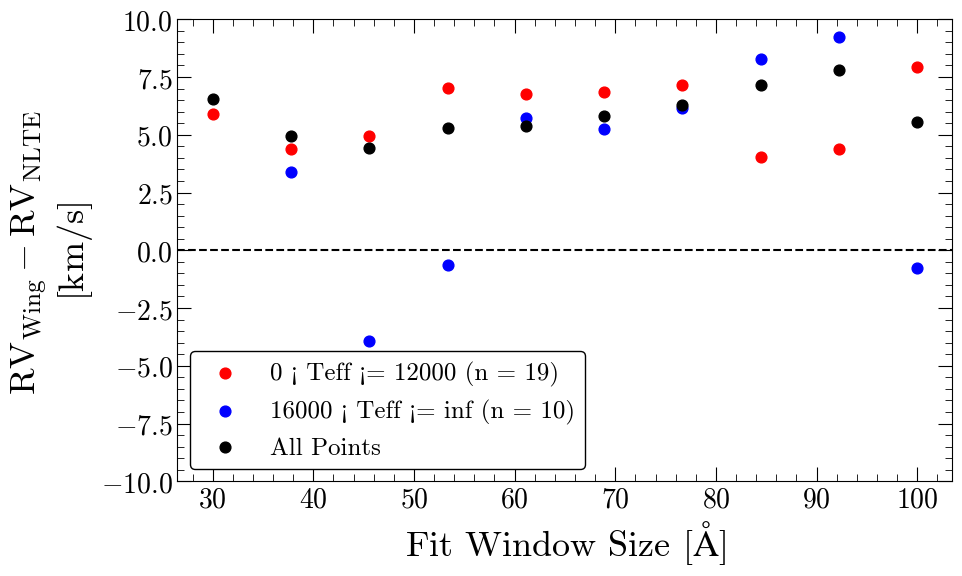

In [13]:
def plot_ensemble(df):
    fig, ax = plt.subplots(nrows = 1, figsize=(10,6))

    colors = {1 : 'red', 3 : 'blue'}
    for edge in np.unique(df.teff_bin)[::2]:
        subset = df.query(f"teff_bin == {edge}")
        diffs = np.array(subset.differentials.tolist(), dtype=float)
        wl = np.array(subset.windows.tolist())[0,1:]

        avg_rows = (np.count_nonzero(~np.isnan(diffs)) // 10)
        mean_diff = np.nanmean(diffs[:,1:], axis=0)
        median_diff = np.nanmedian(diffs[:,1:], axis=0)
        std_diff = np.nanstd(diffs[:,1:], axis=0)

        scatter = {'s' : 40}
        low, hi = range_func(edge)
        ax.scatter(wl, median_diff, label = f'{low} < Teff <= {hi} (n = {len(subset)})', color = colors[edge], s = 60, zorder=10)

    diffs = np.array(df.differentials.tolist(), dtype=float)
    wl = np.array(df.windows.tolist())[0,1:]

    avg_rows = (np.count_nonzero(~np.isnan(diffs)) // 10)
    mean_diff = np.nanmean(diffs[:,1:], axis=0)
    median_diff = np.nanmedian(diffs[:,1:], axis=0)
    std_diff = np.nanstd(diffs[:,1:], axis=0)

    scatter = {'s' : 40}
    low, hi = range_func(edge)
    ax.scatter(wl, median_diff, label = f'All Points', color = 'k', s = 60, zorder=10)

    xmin, xmax = ax.get_xlim()
    #ax.fill_between([xmin,xmax], -ref_e_rv, ref_e_rv, color='green', alpha=0.5, zorder=0)
    ax.set_xlim(xmin, xmax)
    ax.axhline(y = 0, c = 'k', ls = '--')

    hfont = {'fontname':'Helvetica'}
    ax.set_ylim(-10,10)   
    ax.set_xlabel(r'Fit Window Size [$\AA$]')
    ax.set_ylabel('$RV_{Wing} - RV_{NLTE}$ \n$[km /s]$')
    ax.legend()

plot_ensemble(df_masked)